In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2024-06-23 16:04:57.136507: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-23 16:04:57.144540: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-23 16:04:57.242358: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 16:04:59.700394: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
image_size = (256, 256) # that is what we have in our potato image


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory( # allows us to load dataset that we have in our system
    'potato_dataset', #directory_name
    shuffle = True,
    batch_size = 32,
    image_size = image_size
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

we have 2152 files but it is just giving us 68, it is because we have divided 2165 files into 32 batches.

If we do 68 * 32 = 2516

In [7]:
68 * 32

2176

It is because we dont have complete 32 images in one batch

In [8]:
# let's take 1 batch and see

for image_batch, label_batch in dataset.take(2):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 2 0 1 1 0 0 1 2 0 1 1 2 1 1 0 0 1]
(32, 256, 256, 3)
[0 0 0 0 1 0 0 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 2 1 0 1 1 0 1 0 1]


2024-06-23 16:05:07.867201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


image_batch: 32 is batch size, 256, 256 is image size and 3 is rgb_channel

label_batch: three classes (0,1,2) which are  'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy' respectively


2024-06-23 16:05:10.797851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


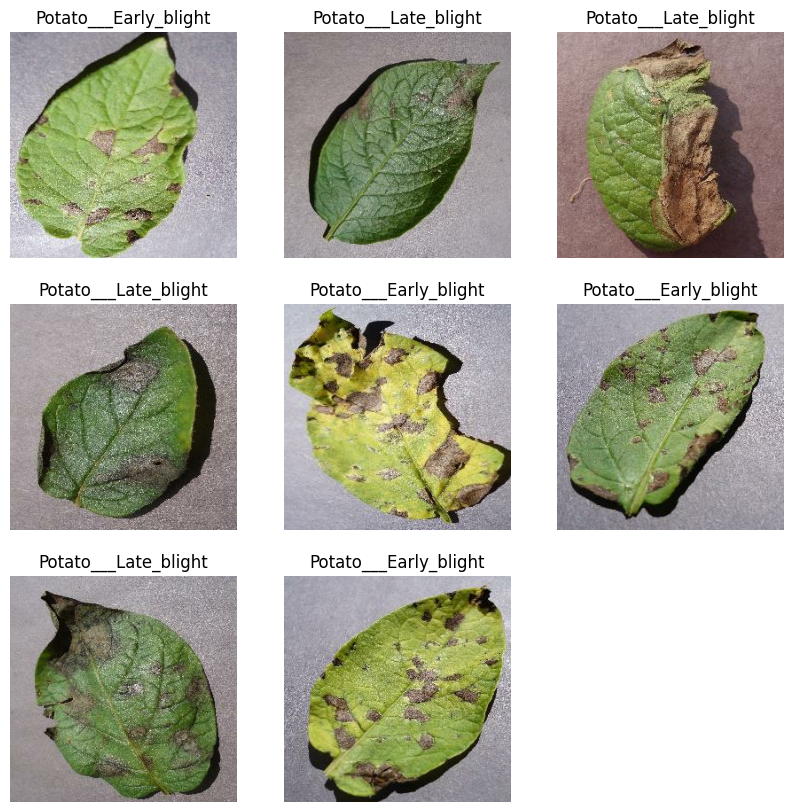

In [9]:
# Let's visualize  Image randomly.
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(2):
    # let's visualize multiples images 
    for i in range(8):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off') # hides x and y axis

Every_time you run this cell, you see different image because it is shuffled

### Now we can divide training and testing size to 80% and 20% respectively.

In [10]:
# 80% is 0.8 so,

train_size = 0.8

len(dataset) * train_size

54.400000000000006

In [11]:
# Let's take 54 as our training sample

train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
# After taken the training sample, we know rest are testing samples

testing_ds = dataset.skip(54)
len(testing_ds)

14

In [13]:
val_size = 0.1

len(dataset) * val_size

6.800000000000001

In [14]:
val_ds = testing_ds.take(6)
len(val_ds)

6

In [15]:
testing_ds = testing_ds.skip(6)
len(testing_ds)

8

In [16]:
def dataset_partiation(ds, train_split=0.8, test_split = 0.1, val_split = 0.1, shuffle=True, shuffle_size = 10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12) # seed can be any number, if you do same seed everytime it gives you same result

    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

    return 

In [17]:
train_ds, val_ds, test_ds = dataset_partiation(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(test_ds)

8

In [20]:
len(val_ds)

6

### Input PipeLine Optimization

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


Cache:  opens and read the image from the disk and does'nt have to open it again for next iteration or epoch. It optimizes input pipeline.

prefetching: If Gpu is busy, prefetch will load next set of batch from the disk and that will imporve the performancs.

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [30]:
resizeAndRescaling= tf.keras.Sequential([
    layers.Resizing(image_size,image_size), # incase we don't have image size of 256
    layers.Rescaling(1.0/255) # by dividing by 255, we will have value in range of 0 to 1, which improves model performance.

])